In [ ]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.12.0


In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# Descargar las imágenes del conjunto de datos de MNIST
(train_images,_),(_,_)=tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

# Se normalizan del rango de -1,1 para poder usar como función de activación
# en la capa final del Generador la función tanh
train_images = (train_images - 127.5)/127.5

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Barajamos y preparamos los datos en lotes
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## **Generador**
Crea una imagen que parece real. En este caso, crea imágenes de 28x28 pixeles.

1. Inicio con Espacio Latente (Ruido).
2. **Convolución Transpuesta**: Invierte el proceso de una Convolución típica. El modelado aprende a añadir detalles cada vez más finos a la imagen.
3. **Salida**: Tanh mapea los valores de los pixeles de la imagen de -1 a 1. Cada valor la intensidad y el color.  



In [ ]:
# El generador recibe como entrada ruido, que puede obtener por ejempo con
# tf.rondom.normal. Debe crear una imagen de 28x28 a partir de este ruido.

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def make_generator_model():
  model = Sequential()
  # Capa densa que recoge el vector de ruido de entrada y lo transforma en
  # un tensor tridimensional, que se va transformando hasta llegar a una salida
  # de 28x28x1
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

  model.add(Reshape((7,7,256)))

  # Aumenta el mapa de características. Lo contrario a la convolución 2D
  model.add(Conv2DTranspose(128,(5,5), strides = (2,2),
                            padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.001)) # Versión modificado de la función de activación
  # ReLU. Está disponible como capa, no como función de activación

  model.add(Conv2DTranspose(64,(5,5),strides=(1,1),
                            padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # tanh tiende a producir
  model.add(Conv2DTranspose(1,(5,5),strides=(2,2),
                            padding='same', activation='tanh'))

  return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       2

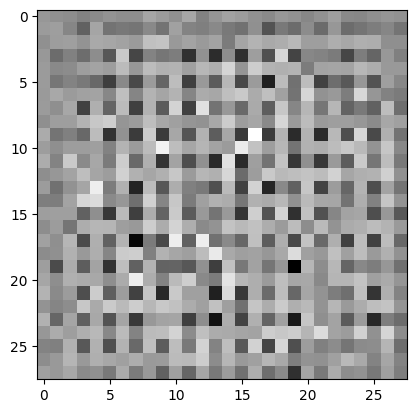

In [ ]:
# Comprobar que la red funciona

noise_dim = 100
noise = tf.random.normal([1,noise_dim])
generated_image=generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [ ]:
#DISCRIMINADOR
# El discriminador recibe imágenes de 28x28x1 píxeles y saca una probabilidad
# que indica si esta imagen de entrada la considera real (en lugar de fake)

from tensorflow.keras.layers import Conv2D, Flatten

def make_discriminador_model():
  model=Sequential()
  model.add(Conv2D(32,(5,5),strides=(2,2),padding='same',
                   input_shape=[28,28,1]))
  model.add(LeakyReLU(alpha=0.001))

  model.add(Conv2D(64,(5,5),strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.001))

  model.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.001))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  return model

discriminador = make_discriminador_model()
discriminador.summary()

# Tres capas convolucionales de 32,64 y 128 neuronas, con función de activación
# LeakyReLU y BatchNormalization. La últimma capa es una capa densa con una función
# de activación sigmoide


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    
                                                      

In [ ]:
#Podemos comprobar que el discriminador funciona con el siguiente código
decision = discriminador(generated_image)
print(decision)
#El resultado es irrelevante, ya que el Driscriminador aún no está entrenado

tf.Tensor([[0.5006342]], shape=(1, 1), dtype=float32)


## **Proceso de Aprendizaje del Discriminador**
**Entrenamiento con Imágenes Reales**: Durante el entrenamiento, el discriminador recibe primero un conjunto de imágenes reales del dataset. Para estas imágenes, se espera que el discriminador produzca una salida cercana a 1 (indicando "real"). En esta etapa, los pesos del discriminador se ajustan para maximizar la probabilidad asignada a las imágenes reales.

**Entrenamiento con Imágenes Generadas**: A continuación, el discriminador recibe un conjunto de imágenes generadas por el generador. Para estas imágenes, el objetivo es que el discriminador produzca una salida cercana a 0 (indicando "falso" o "generado"). Nuevamente, los pesos del discriminador se ajustan, pero esta vez para minimizar la probabilidad asignada a las imágenes generadas.

In [ ]:
# Funciones de pérdida y optimizadores
# Tenemos dos redes neuronales, así que se requieren dos funciones de pérdida y
# dos optimizadores

# Necesitamos especificar con el método fit() que esta red neuronal tiene dos
# funciones de pérdida y dos optimizadores interrelacionadas

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Función que compara el batch de imágenes reales predecidas por el discriminador
# con un array de Unos y otro de Ceros

def discriminador_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),
                            real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),
                            fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Construir la función generator_loss para cuantificar una loss del Generador
# Debe cuantificar qué tan bien fue capaz de engañar al discriminador
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizadores
# El optimizador Adam tiene un rendimiento superiror a otro métodos en las GAN
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# ENTRENAMIENTO
# NO SE PUEDE especificar el método fit() con una red que tiene dos funciones
# de pérdida y dos optimizadores

# Se utilizará la API de más bajo nivel de TensorFlow. Cada operación se implementa
# utilizando un código escrito y compilado en C++

# La diferenciación automática es una técnica clave para optimizar los modelos de
# aprendizaje automático. Tensorflow proporciona la API tf.GradientTape, que calcula
# el gradiente de cálculo con respecto a sus variables de entrada.


# La función train_step representa un paso del bucle de entrenamiento que hemos programado
# Empieza el paso 1 con la creación de un conjunto de semillas de ruido con el que
# el Generador pueda generar las imágenes fake correspondientes(recordemos que estamos
# procesando las imágenes por lostes de tamaño BATCH_SIZE y que, por tanto, genera un
# vector de semillas, no una sola semilla)
@tf.function

def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Genera un batch de imágenes fake

  # Dos contextos: Generador(gen_tape) y Discriminador(disc_tape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # se genera un batch de imágenes fake
    generated_images = generator(noise,training=True)

    # Se usa el Discriminador para clasificar un batch de imágenes reales
    # extraídas del conjunto MNIST (recibidas como argumento) y un batch
    # de imágenes fake acabadas de producir por el Generador
    real_output = discriminador(images, training=True)
    # El argumento Training es booleano y se puede especificar si usamos
    # el modelo para entrenamiento o para inferencia
    fake_output = discriminador(generated_images, training=True)

    # Paso 2. Cuando ya tenemos los valores obtenidos por el Gen. y el Dis.
    # se calcula la loss de ambos modelo con las funciones que hemos definido
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminador_loss(real_output,fake_output)

  # Paso 3. Propagar hacia atrás la loss para que llegue a todas las variables
  # que conforman los parámetros(entrenables) para cada una de las dos redes neuronales.
  gradients_of_generator = gen_tape.gradient(gen_loss,
                                             generator.trainable_variables)

  gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                  discriminador.trainable_variables)
  # Paso 4. Usar esta información de los gradientes propagada para actualizar con el
  # algoritmo de descenso del gradiente las variables correspondientes a los parámetros
  # entrenables de cada una de las redes neuronales.
  generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                         generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                              discriminador.trainable_variables))


In [ ]:
# Para monitorizar visualmente el avance del entrenamiento
import time
grid_size_x = 10
grid_size_y = 10
seed = tf.random.normal([grid_size_x*grid_size_y , noise_dim])


# El primer bucle tiene tanas iteraciones como epochs, y el segundo itera para
# todos los batch del dataset.
# El cuerpo del bucle llama al método train_step, que realiza todo el trabajo requerido
# para calcular lo loss y actualizar los parámetros de las dos redes, para todas
# las imágenes de un batch en una epoch
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_images(generator, seed)
    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))


In [ ]:
# Bucle que muestra en pantalla tantas predicciones como se le han indicado
# mediante las variables grid_size_x y grid_size_y, que son 10x10(totla: 100)
def generate_images(model,test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(grid_size_x,grid_size_y))
  for i in range(predictions.shape[0]):
    plt.subplot(grid_size_x,grid_size_y,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,
               cmap='gray')
    plt.axis('off')
  plt.show()

In [ ]:
# ENTRENAR EL MODELO
EPOCHS = 100
train(train_dataset, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Aunque las imágenes no son perectas, muchas de ellas son fácilmente reconocibles
# como números reales

